#### Установка зависимостей

In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
!unzip TRAIN_PREPARED.csv.zip -d .

Archive:  TRAIN_PREPARED.csv.zip
  inflating: ./TRAIN_PREPARED.csv    
   creating: ./__MACOSX/
  inflating: ./__MACOSX/._TRAIN_PREPARED.csv  


In [3]:
TRAIN_PREPARED = 'TRAIN_PREPARED.csv'
TEST_PREPARED = 'TEST_PREPARED.csv'
TRAIN_ADDITIONAL = 'TRAIN_ADDITIONAL_DATA.csv'
TEST_ADDITIONAL = 'TEST_ADDITIONAL_DATA.csv'

In [214]:
def preprocessing_train(filename):
    df = pd.read_csv(filename)
    df = df.set_index('user')
    Y_train = df['label']
    X_train = df.drop('label', axis=1)
    X_train = X_train.drop(['cut_date', 'first_date', 'last_date'], axis=1)
    
    return X_train, Y_train

def preprocessing_test(filename):
    df = pd.read_csv(filename)
    df = df.set_index('user')
    X_test = df.drop(['cut_date', 'first_date', 'last_date'], axis=1)
    
    return X_test


def xgb_model(X_train, Y_train, baseline=False):
    # данные параметры подобраны с помощью GridSearchCV
                                 
    if baseline:
        xgb_clf = xgb.XGBClassifier(objective="binary:hinge",
                                nthread=4, 
                                seed=42)
    else:
        xgb_clf = xgb.XGBClassifier(objective="binary:hinge",
                                    nthread=4, 
                                    seed=42,
                                    gamma=0.01,
                                    learning_rate=0.01,
                                    max_depth=7,
                                    n_estimators=100,
                                    reg_lambda=0.01)
        
    xgb_clf.fit(X_train, Y_train)
    Y_pred = xgb_clf.predict(X_train)
    
    print(f'Train score:{roc_auc_score(Y_train, Y_pred)}')

    return xgb_clf

def lgbm_model(X_train, Y_train, baseline=False):
    d_train = lgbm.Dataset(X_train, Y_train)

    params = {
        'objective' :'binary',
        'learning_rate' : 0.1,
        'num_leaves' : 76,
        'feature_fraction': 0.64, 
        'bagging_fraction': 0.8, 
        'bagging_freq':1,
        'boosting_type' : 'gbdt',
        'metric': 'roc_auc'
    }
    
    params_init = {
        'objective' :'binary',
        'learning_rate' : 0.1,
        'bagging_freq':1,
        'boosting_type' : 'gbdt',
        'metric': 'roc_auc'
    }
    
    if baseline:
        bst = lgbm.train(params_init, d_train, 50, verbose_eval=50)
    else:
        bst = lgbm.train(params, d_train, 50, verbose_eval=50)
        
    Y_pred = bst.predict(X_train)
    print(f'Train score:{roc_auc_score(Y_train, Y_pred)}')  

    return bst

def cvKfold(X,y):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    kf.get_n_splits(X, y)
    return kf

def lr_model(X_train, y_train, C):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    regr = LogisticRegression(C = C,  random_state=241, n_jobs=-1)
    kf = cvKfold(X_train, y_train)
    cvs = cross_val_score(regr, X_train, y_train, scoring='roc_auc', cv=kf, n_jobs=-1)
    cvs_val = cvs.mean()
    print (f'C_regularization: {C}\ncross-validation score: {cvs_val}')
    
def lr_model_best_c(X_train, y_train):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    regr = LogisticRegression(C = 0.1,  random_state=241, n_jobs=-1)
    kf = cvKfold(X_train, y_train)
    cvs = cross_val_score(regr, X_train, y_train, scoring='roc_auc', cv=kf, n_jobs=-1)
    cvs_val = cvs.mean()
    print (f'C_regularization: {0.1}\ncross-validation score: {cvs_val}')
    regr.fit(X_train, y_train)
    
    return regr
    
    
def concat_answer(X_test, Y_pred_test):
    X_index = pd.DataFrame(X_test.index)
    Y_test = pd.DataFrame(Y_pred_test, columns=['prediction'])
    result = pd.concat([X_index, Y_test], axis=1)
    res_test = result.set_index('user')
    
    return res_test

def predict_binary(X_test, model):
    Y_pred = model.predict(X_test)
    Y_pred_binary = np.where(Y_pred>0.5,1,0)
    return Y_pred_binary


In [215]:
def all_models(X_train, Y_train, baseline=False): #without additional data
    #XGBoost
    print('==========XGBoost==========')
    xgb_clf = xgb_model(X_train, Y_train, baseline)
    
    #Logistic regression
    print('==========Logistic regression==========')
    logreg = lr_model_best_c(X_train, Y_train)
    models = [xgb_clf, logreg] #models supporting probabilities
 
     #LightGBM - best score for train = 0.8265
    print('==========LightGBM==========')
    lgbm_clf = lgbm_model(X_train, Y_train, baseline)


In [131]:
X_train, Y_train = preprocessing_train(TRAIN_PREPARED)
all_models(X_train=X_train, Y_train=Y_train, baseline=True)

==========XGBoost==========
Train score:0.5072214989888634
==========Logistic regression==========
C_regularization: 0.1
cross-validation score: 0.6628781775590704
==========LightGBM==========
Train score:0.7547578705985554


Baseline для LightGBM показал неплохое качество на обучающей выборке. Используем additional data и аггрегацию данных для лучшего результата

In [132]:
def prep_additional_data(df_add):
    df_add['trial'] = df_add['trial'].fillna(0).astype('int32')
    d = {'CREATE': 1, 'DELETE': 0}
    df_add['action'] = df_add['action'].fillna(0).map(d).astype('int32')
    return df_add

def last_action(df_add):
    df_add_data = df_add.groupby('user')['calday'].agg('max')
    df_last_date = pd.merge(df_add, df_add_data, on='user')
    df_last = df_last_date[df_last_date['calday_x']==df_last_date['calday_y']].drop('calday_y', axis=1)
    return df_last

def last_known_day(df):
    df_day = df.groupby('user')['days_to_end'].agg('min')
    df_last_day_known = pd.merge(df, df_day, on='user')
    users = df['user'].unique()
    df_lday = df_last_day_known[df_last_day_known['days_to_end_x']==df_last_day_known['days_to_end_y']].drop('days_to_end_y', axis=1)
    return df_lday

def str_to_date(date: str):
    return datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")


In [133]:
def add_data(TRAIN_PREPARED, TRAIN_ADDITIONAL):
    df = pd.read_csv(TRAIN_PREPARED)
    df_add = pd.read_csv(TRAIN_ADDITIONAL)
    df_add = prep_additional_data(df_add)
    df_last = last_action(df_add)
    df_lday = last_known_day(df)
    df_last['bin_action'] = (df_last.action==1).astype('int32')
    df_last['bin_trial'] = (df_last.trial==0).astype('int32')
    df_add_prep = df_last.drop(['calday_x', 'action'], axis=1)
    df_merged = pd.merge(df_lday, df_add_prep, on='user')
    df_merged['delta'] = df_merged['last_date'].apply(str_to_date) - df_merged['first_date'].apply(str_to_date)
    df_merged['delta'] = df_merged['delta'].apply(lambda x: x.days)
    df_merged_prep = df_merged.drop(['cut_date', 'first_date', 'last_date'], axis=1).set_index('user')
    
    return df_merged_prep

def extract_label(df):
    Y_train = df['label']
    X_train = df.drop(['label'], axis=1)
    return X_train, Y_train
    

# ==========Исследование данных==========

In [134]:
df = pd.read_csv(TRAIN_PREPARED)
df_add = pd.read_csv(TRAIN_ADDITIONAL)

In [135]:
df_add['trial'] = df_add['trial'].fillna(0).astype('int32')
d = {'CREATE': 1, 'DELETE': 0}
df_add['action'] = df_add['action'].fillna(0).map(d).astype('int32')
df_add['churn'] = df_add['action']|df_add['trial']
index_not_churn = df[df.label==0]['user'].unique()
index_churn = df[df.label==1]['user'].unique()

In [136]:
df_last = last_action(df_add)

# Не уходят те, у кого последнее действие ('action') == 1, то есть 'CREATE'

In [137]:
df_last.set_index('user').loc[index_not_churn]['action'].value_counts(normalize=True)

1    0.96637
0    0.03363
Name: action, dtype: float64

In [138]:
df_churn = df[df.label==1].groupby('user').agg('max')
df_last_day = df[df.days_to_end==0]
ind_nochurn = df_last_day[df_last_day.label==0]['user'].unique()
ind_churn = df_last_day[df_last_day.label==1]['user'].unique()

## - 90% тех, кто не пользовался пробным периодом, ушли. 
## - 94% тех, чье последнее действие CREATE, остались
## - 83% тех, чье последнее действие DELETE, ушли.

# Значит, если в последней записи у них action==0, trial==0, то они уйдут


In [139]:
df_last.set_index('user').loc[ind_churn]['trial'].value_counts(normalize=True)

0    0.902271
1    0.097729
Name: trial, dtype: float64

In [140]:
df_last.set_index('user').loc[ind_churn]['action'].value_counts(normalize=True)

0    0.833739
1    0.166261
Name: action, dtype: float64

In [141]:
df_last.set_index('user').loc[ind_nochurn]['action'].value_counts(normalize=True)

1    0.949402
0    0.050598
Name: action, dtype: float64

In [142]:
df_last.set_index('user').loc[ind_nochurn]['trial'].value_counts(normalize=True)

0    0.504113
1    0.495887
Name: trial, dtype: float64

# Тут данные только за последний известный день для пользователей
## - 73% тех, кто не пользовался пробным периодом, ушли. 
## - 96% тех, чье последнее действие CREATE, остались

# Значит, если в последней записи у них trial==0, то они скорее всего уйдут

In [143]:
df_lday = last_known_day(df)

In [144]:
ind_nochurn = df_lday[df_lday.label==0]['user'].unique()
ind_churn = df_lday[df_lday.label==1]['user'].unique()

In [145]:
df_last.set_index('user').loc[ind_nochurn]['action'].value_counts(normalize=True)

1    0.96637
0    0.03363
Name: action, dtype: float64

In [146]:
df_last.set_index('user').loc[ind_churn]['trial'].value_counts(normalize=True)

0    0.732392
1    0.267608
Name: trial, dtype: float64

# ==========Изменение score после feature engineering==========

In [147]:
df_merged_prep = add_data(TRAIN_PREPARED, TRAIN_ADDITIONAL)
X_train, Y_train = extract_label(df_merged_prep)

Поработали с данными, посмотрим, как изменилось качество

In [148]:
all_models(X_train, Y_train, baseline=True)

==========XGBoost==========
Train score:0.7311641673813236
==========Logistic regression==========
C_regularization: 0.1
cross-validation score: 0.857720205509416
==========LightGBM==========
Train score:0.9196112128421291


### Качество ощутимо улучшилось. Для проверки разобьем обучающую выборку на обучающую и валидационную и посмотрим качество

In [209]:
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [210]:
xgb_clf = xgb_model(X_train=X_train_new, Y_train=Y_train_new, baseline=True)
Y_pred_new = predict_binary(X_test_new, xgb_clf)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.7306522019705588
Test score:0.7320923570183101


### Колоссальное различие значений метрики на train и test говорит о том, что логистическая регрессия не подходит, поэтому подбирать для нее параметры не будем

In [211]:
lr_clf = lr_model_best_c(X_train_new, Y_train_new)
Y_pred_new = predict_binary(X_test_new, lr_clf)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

C_regularization: 0.1
cross-validation score: 0.8541783202188291
Test score:0.5781939745044296


### LightGBM показыват более высокое качество на тестовой выборке относительно XGBoost, но XGBoost дает небольшой разброс на тестовой и обучающей выборке

In [212]:
lgbm_clf = lgbm_model(X_train=X_train_new, Y_train=Y_train_new, baseline=True)
Y_pred_new = lgbm_clf.predict(X_test_new)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.9306140423117575
Test score:0.8724303903095859


# ==========Учет feature importances==========
Уберем колонки с небольшой значимостью, для ускорения вычислений

In [158]:
import matplotlib.pyplot as plt

In [159]:
def extract_features(feature_importances, min_score=0.01):
    column_slice = np.where(feature_importances > min_score)
    return column_slice

def reduced_data(X, importatnt_features):
    X_reduced = X.iloc[:, list(importatnt_features[0])]
    return X_reduced

In [160]:
def plot_fi(feature_importances, features):
    plt.figure(figsize=(20, 6))
    plt.yscale('log', nonposy='clip')
    plt.bar(range(len(feature_importances)), feature_importances, align='center')
    plt.xticks(range(len(feature_importances)), features, rotation='vertical')
    plt.title('Feature importance')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()

In [161]:
feature_importances = xgb_clf.feature_importances_

In [162]:
important_features = extract_features(feature_importances, 0.005)
X_train_reduced = reduced_data(X_train_new, important_features)
X_test_reduced = reduced_data(X_test_new, important_features)

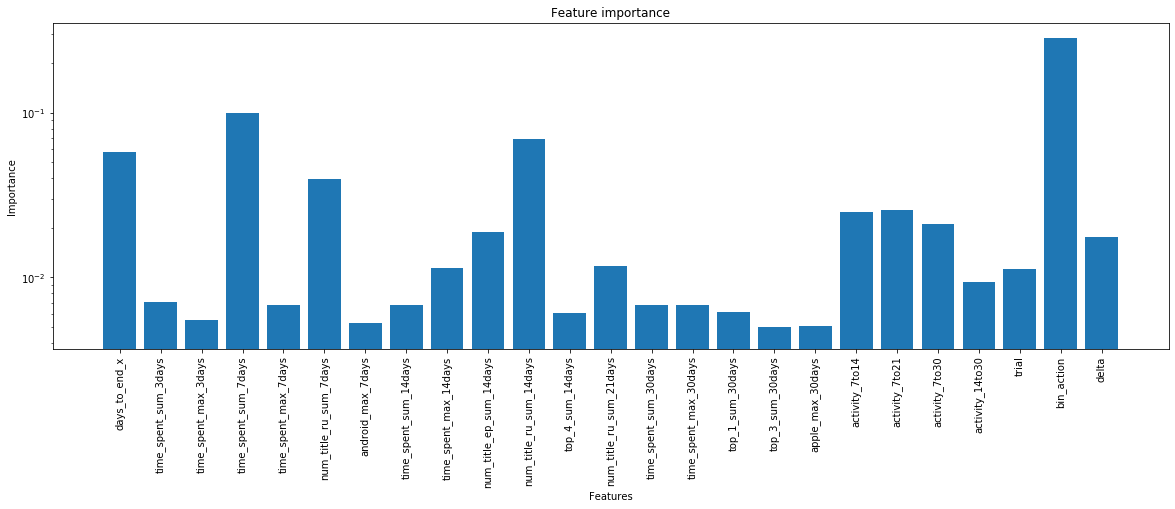

In [163]:
plot_fi(feature_importances[important_features[0]], X_train_reduced.columns)

Качество незначительно ухудшилось, а скорость выполнения заметно возросла

In [164]:
all_models(X_train_reduced, Y_train_new, baseline=True)

==========XGBoost==========
Train score:0.7306330699861474
==========Logistic regression==========
C_regularization: 0.1
cross-validation score: 0.8565927076195392
==========LightGBM==========
Train score:0.919439042584617


In [213]:
lgbm_clf = lgbm_model(X_train_reduced, Y_train_new, baseline=True)
Y_pred_new = lgbm_clf.predict(X_test_reduced)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.919439042584617
Test score:0.8692779573868994


In [168]:
xgb_clf = xgb_model(X_train_reduced, Y_train_new, baseline=True)
Y_pred_new = predict_binary(X_test_reduced, xgb_clf)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.7306330699861474
Test score:0.7327006295243929


# ==========Подбор параметров с помощью GridSearchCV==========

*Очень долго считается*

In [29]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [33]:
xgb_model = xgb.XGBClassifier(objective="binary:hinge",
                             nthread=4,
                              seed=42)

params = {'gamma':[0.1, 0.01],
          'learning_rate': [0.1, 0.01],
          'reg_lambda': [0.1, 0.01],
          'max_depth': range (2, 10, 1),
          'n_estimators': range(60, 180, 40),
         }


search = GridSearchCV(xgb_model, 
                      params, 
                      scoring='roc_auc')

search.fit(X_train_reduced, Y_train_new)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:hinge',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.1, 0.01], 'learning_rate': [0.1, 0.01], 'reg_lambda': [0.1, 0.01], 'max_depth': range(2, 10), 'n_estimators': range(60, 180, 40)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.772 (std: 0.008)
Parameters: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.01}



In [126]:
xgb_clf = xgb_model(X_train_reduced, Y_train_new)
Y_pred_new = predict_binary(X_test_reduced, xgb_clf)
print(f'Test score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.7983211149408155
Train binary score:0.7983211149408155
Test score:0.7755729642533224


Модели дают предсказание в долях вероятности, но целевая переменная содержит только `0` и `1`. Преобразуем вероятностный predict в бинарный и сравним `roc_auc_score`

## XGBoost with objective="binary:logistic"

In [186]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                                    nthread=4, 
                                    seed=42,
                                    gamma=0.01,
                                    learning_rate=0.01,
                                    max_depth=7,
                                    n_estimators=100,
                                    reg_lambda=0.01)
        
xgb_clf.fit(X_train_reduced, Y_train_new)
Y_pred = xgb_clf.predict(X_train_reduced)
print(f'Train score:{roc_auc_score(Y_train_new, Y_pred)}')

# xgb_clf = xgb_model(X_train_reduced, Y_train_new)
Y_pred_new = xgb_clf.predict(X_test_reduced)
Y_pred_proba_new = xgb_clf.predict_proba(X_test_reduced)
print(f'Test probability score:{roc_auc_score(Y_test_new, Y_pred_proba_new[:,1])}')
print(f'Test binary score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.7583483953188004
Test probability score:0.8679357696585531
Test binary score:0.7380771895300154


## XGBoost with objective="binary:hinge"

In [197]:
xgb_clf = xgb.XGBClassifier(objective="binary:hinge",
                                    nthread=4, 
                                    seed=42,
                                    gamma=0.01,
                                    learning_rate=0.01,
                                    max_depth=7,
                                    n_estimators=100,
                                    reg_lambda=0.01)
        
xgb_clf.fit(X_train_reduced, Y_train_new)
Y_pred = xgb_clf.predict(X_train_reduced)
print(f'Train score:{roc_auc_score(Y_train_new, Y_pred)}')

# xgb_clf = xgb_model(X_train_reduced, Y_train_new)
Y_pred_new = xgb_clf.predict(X_test_reduced)
Y_pred_proba_new = xgb_clf.predict_proba(X_test_reduced)
print(f'Test probability score:{roc_auc_score(Y_test_new, Y_pred_proba_new[:,1])}')
print(f'Test binary score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.7983211149408155
Test probability score:0.7755729642533224
Test binary score:0.7755729642533224


In [188]:
lgbm_clf = lgbm_model(X_train_reduced, Y_train_new, baseline=True)
Y_pred_new = predict_binary(X_test_reduced, lgbm_clf)
Y_pred_proba_new = lgbm_clf.predict(X_test_reduced)
print(f'Test probability score:{roc_auc_score(Y_test_new, Y_pred_proba_new)}')
print(f'Test binary score:{roc_auc_score(Y_test_new, Y_pred_new)}')

Train score:0.919439042584617
Test probability score:0.8692779573868994
Test binary score:0.7469628209118565


## В итоге будем использовать: 
### - LightGBM с первоначальными параметрами для probability submission ('prediction' $\in$ [0, 1])
### - XGBoost c подобранными GridSearch параметрами для binary submission ('prediction'={0, 1})

# Оформление sumbission

In [205]:
def make_submission(X_test, Y_pred, prob=False):
    X_index = pd.DataFrame(X_test.index)
    y_pred = pd.DataFrame(Y_pred, columns=['prediction'])
    result = pd.concat([X_index, y_pred], axis=1)
    res = result.set_index('user')
    if prob:
        res.apply(lambda x: round(x,3)).to_csv('submission_proba.csv')
    else:
        res.to_csv('submission.csv')

In [206]:
def final_model(TRAIN_PREPARED, TRAIN_ADDITIONAL, TEST_PREPARED, TEST_ADDITIONAL):
    #prepare data
    df_merged_prep = add_data(TRAIN_PREPARED, TRAIN_ADDITIONAL)
    X_train, Y_train = extract_label(df_merged_prep)
    X_test = add_data(TEST_PREPARED, TEST_ADDITIONAL)
    
    #delete features
    lgbm_clf = lgbm_model(X_train, Y_train, baseline=True)
    feature_importances = lgbm_clf.feature_importance()
    important_features = extract_features(feature_importances, 0.005)
    X_train_reduced = reduced_data(X_train, important_features)
    X_test_reduced = reduced_data(X_test, important_features)
    
    #predict probability
    lgbm_clf = lgbm_model(X_train_reduced, Y_train, baseline=True)
    Y_pred = lgbm_clf.predict(X_test_reduced)
    make_submission(X_test_reduced, Y_pred, prob=True)
    
    #predict binary
    xgb_clf = xgb_model(X_train_reduced, Y_train)
    Y_pred_new = xgb_clf.predict(X_test_reduced)
    make_submission(X_test_reduced, Y_pred_new)
    
    return Y_pred

In [207]:
Y_pred = final_model(TRAIN_PREPARED, TRAIN_ADDITIONAL, TEST_PREPARED, TEST_ADDITIONAL)

Train score:0.9196112128421291
Train score:0.9196112128421291
Train score:0.7984018788874797


# Результат с вероятностями в файле `'submission_proba.csv'`
# Результат с бинарными значениями {0,1} в файле `'submission.csv'`